<div style="text-align: center;">

# **White Papers**  
### Python para la Inteligencia Artificial  
#### Máster en Inteligencia Artificial  
#### Universidad Internacional de Valencia  

<br>

![Logo VIU](logo_viu.png)  

<br><br>

## **"Dask: Parallel Computation with Blocked Algorithms and Task Scheduling"**

<br><br>

**Autor:** Marcos José Díaz Gutiérrez  
**Fecha:** 19 de noviembre de 2024  

</div>

---


# 📖 Índice

1. ✨ **[Introducción](#1-introducción)**  
   Descubre los conceptos básicos y el propósito de esta guía.

2. 🔍 **[¿Cómo funciona Dask por detrás?](#2-cómo-funciona-dask-por-detrás)**  
   Una mirada bajo el capó del motor de Dask.

3. 🧮 **[El `dask.array`](#3-el-daskarray)**  
   Exploramos cómo usar arrays distribuidos con Dask.

4. ⚔️ **[Dask vs NumPy](#4-dask-vs-numpy)**  
   Comparativa práctica entre estas dos herramientas.

5. 📚 **[Referencias](#5-referencias)**  
   Fuentes de información y bibliografía adicional.


# 1. Introducción

El artículo empieza con una oración clara y contundente: "la comunidad de Python rara vez saca provecho de la computación el paralelo". ¿Qué es la computación en paralelo? La computación en paralelo es un enfoque de procesamiento en el que varias tareas se realizan a la vez; en lugar de una tarea después de otra (computación en serie). Por supuesto, no todas las tareas son paralelizables: por ejemplo, cocinando pasta primero debemos poner el agua a hervir y luego echar la pasta. Sin emabrgo, en tareas como atender a los clientes de un supermercado, puede ser interesante abrir varias cajas para repartir la carga de trabajo entre éstas.

En nuestros ordenadores, estas cajas para pagar en el supermercado son los nucleos de nuestra CPU. Estos núcleos son como pequeños cerebros dentro del procesador que realiza cálculos y ejecuta instrucciones. En la intoducción de su paper, Matthew Rocklin, asegura que código escrito en Numpy o Pandas rara vez aprovecha los procesos en paralelo ya que suelen trabajar con volumenes de datos que caben en memoria. Sin embargo, ¿qué ocurre cuando estos datos no caben en memoria? ¿Qué ocurre cuando, a pesar de gestionar manualmente la memoria de nuestra máquina, nos sigue saliendo el fastidioso error de "MemoryError: Unable to allocate..."?

En esta librería, no se reinventa Numpy con el dask.array, o Pandas con el dask.dataframe, sino construye sobre ambas librerías para añadir las funcionalidades que hemos mencionado hasta ahora.

En este trabajo, Rocklin demuestra cómo Dask, específicamente con su módulo dask.array, puede manejar eficientemente datos fuera de memoria y emplear algoritmos bloqueados para dividir tareas grandes en subtareas más pequeñas. La introducción plantea un desafío claro: alinear el ecosistema científico de Python con las capacidades del hardware moderno, utilizando herramientas que sean accesibles, eficientes y prácticas para la comunidad de desarrolladores.

# 2. ¿Cómo funciona Dask por detrás?

Cuando instanciamos un objeto **dask.array**, **no se crean datos reales ni se realizan cálculos inmediatamente**. En su lugar, lo que ocurre es que el array se divide en **bloques**, y se construye un **gráfico de tareas** que describe cómo deben procesarse esos bloques.

La clave de la eficiencia de Dask radica en este comportamiento: al definir un objeto, simplemente estamos especificando una secuencia de operaciones que **aún no se ejecutan**. Esta secuencia de acciones queda representada en un **gráfico de tareas**.

**¿Qué es un DAG?** Desde un punto de vista técnico, estos gráficos de tareas se conocen como **DAGs** (*Directed Acyclic Graphs*), o gráficos dirigidos acíclicos. En este contexto:

- Los **nodos** del grafo representan las tareas a realizar (por ejemplo, una operación matemática o la lectura de datos).
- Las **aristas** indican el flujo de dependencias entre las tareas, es decir, el orden en el que deben ejecutarse.
- El término **acíclico** significa que no hay ciclos, es decir, no existe un camino que permita volver al mismo nodo desde el que se partió. Esto asegura que las tareas no tengan dependencias circulares.

**Ejecución Diferida**: Dask utiliza este enfoque para optimizar la ejecución. Las tareas definidas en el **DAG** no se ejecutan hasta que es estrictamente necesario, por ejemplo, cuando se llama al método `.compute()`. Esto permite planificar, paralelizar y administrar eficientemente las operaciones.

En cierto sentido, Dask recuerda mucho a la forma y sustancia de Spark con grafos de ejecución, retrasando la ejecución de tareas, implementando DAGs... La cuestión de esta tarea no es Spark, pero lo conozco y me ha llamado la atención sus similitudes.

# 3. El dask.array

A continuación, instanciamos un objeto de la clase dask.array:

In [12]:
import dask.array as da

# Crear un Dask Array con argumentos válidos
dask_array = da.arange(
    0,                 # start: Límite inferior del rango.
    100,               # stop: Límite superior del rango (sin incluir).
    1,                 # step: Incremento entre elementos consecutivos.
    dtype='int32',     # dtype: Tipo de datos de los elementos.
    chunks=20          # chunks: Tamaño de los bloques en los que se divide el array.
)

# Mostrar información del Dask Array
print(dask_array)


dask.array<arange, shape=(100,), dtype=int32, chunksize=(20,), chunktype=numpy.ndarray>


- arange: es el nombre automático que Dask asigna a este objeto en el gráfico de tareas.
- shape=(100,): es la forma del array. En este caso unidimensional de 100 elementos.
- dtype=int32: tipo de dato de los elementos del array.
- chunksize=(20,): indica el tamaño de los bloques en los que está divido el array. En este caso cada bloque tiene 20 elementos, lo que generará 5 bloques: [0,19], [20,39], [40,59], [60,79] y [80,99]
- chunktype=numpy.ndarray: indica el tipo de cada bloque del array. En este caso, cada bloque es un numpy.ndarray

A continuación, visualicemos el grafo de ejecución de este objeto:

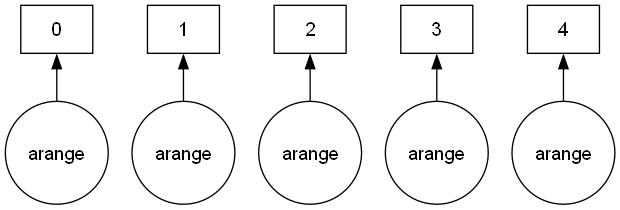

In [13]:
import os # Ignorar
os.environ["PATH"] += os.pathsep + r"C:\Users\mjdiaz\Graphviz\Graphviz-12.2.0-win64\bin" # Ignorar

dask_array.visualize()

Este gráfico representa el **grafo de tareas** generado por Dask para el `dask.array` creado con `da.arange`. El grafo muestra cómo Dask divide el array en bloques y las dependencias entre las tareas necesarias para calcular cada bloque.

1. **Nodos Circulares (Tareas `arange`)**:
   - Cada círculo representa una tarea en el grafo.
   - En este caso, cada tarea corresponde a una operación de `arange`, que genera un bloque del array.

2. **Nodos Rectangulares (Resultados por Bloque)**:
   - Cada nodo rectangular indica un bloque generado por una tarea `arange`.
   - Los bloques están numerados como `0`, `1`, `2`, `3`, `4`.

3. **Flechas (Dependencias)**:
   - Las flechas indican que el nodo rectangular depende directamente de la tarea `arange` correspondiente.
   - Por ejemplo, el bloque `0` es generado por la tarea `arange` que está justo debajo.



Para ver un grafo más representativo, crearemos dos dask.arrays, el primero lo multiplicaremos por 2, y por ultimo sumaremos el nuevo array primero con el segundo y visualizaremos su grafo de ejecución: 

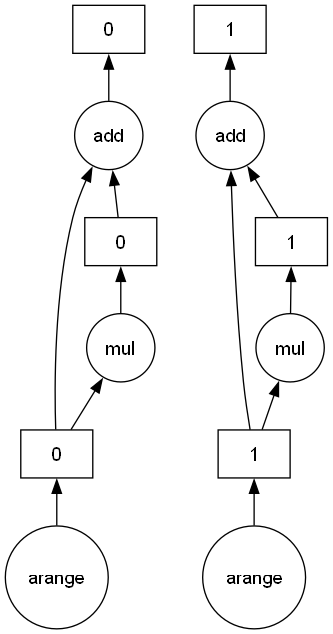

In [14]:
import dask.array as da

# Crear dos dask.arrays
# array1 = da.arange(20, chunks=5)
# array2 = da.arange(20, chunks=5)
array1 = da.arange(10, chunks=5)
array2 = da.arange(10, chunks=5)

# Operaciones con los arrays
array1_multiplied = array1 * 2
result = array1_multiplied + array2

# Visualizar el grafo de ejecución
result.visualize()

Este grafo representa las operaciones realizadas sobre dos `dask.arrays` (`array1` y `array2`) y sus dependencias:

1. **`arange`**: Crea los bloques individuales de `array1` y `array2`.

2. **`mul`**: Multiplica cada bloque de `array1` por 2.

3. **`add`**: Suma los bloques resultantes de `mul` con los bloques correspondientes de `array2`.

**Flujo de Operaciones**: **`arange` (bloque de `array1`) → `mul` → `add` (con el bloque de `array2`)**.

**¿Por qué parece que hay dos grafos repetidos, pero cambiando el 0 por un 1?** Cada grafo corresponde a un chunk de los arrays. Como cada array tiene 10 elementos, y el chunksize es 5 se generan 2 bloques. Cada dibujo de arriba hace referencia al DAG de cada bloque. Se anima al lector a cambiar el codigo de arriba para poner más elementos distribuidos de formas diferentes, haciendo que el visual contenga más DAGs.


# 4. Dask vs NumPy

En este experimento, compararemos el rendimiento entre **NumPy** y **Dask** al realizar operaciones sobre datos de gran tamaño. Debido a que NumPy es muy rápido para datos que caben en memoria, trabajaremos con datos lo suficientemente grandes como para que el manejo de memoria y el paralelismo de Dask muestren sus ventajas.

El objetivo es evaluar:
- **Tiempo de ejecución**: ¿Qué tan rápido se completan las operaciones en NumPy vs. Dask?
- **Uso de memoria**: ¿Cómo manejan los datos ambas bibliotecas cuando exceden la memoria disponible?

## **Creación de los Datos**

Primero, generaremos un array de datos aleatorios con un tamaño muy grande (por ejemplo, 50,000 x 50,000). Este tamaño es suficiente para que los recursos del sistema se vean exigidos, mostrando así las diferencias entre NumPy y Dask.

El array será utilizado para realizar operaciones matemáticas sencillas, como la suma de todos sus elementos.


In [15]:
import numpy as np
import dask.array as da
import time

shape = (50000, 50000)

try:
    start = time.time()
    numpy_array = np.random.random(shape)  
    print(f"Array de NumPy creado con éxito. Tiempo: {time.time() - start:.2f} segundos.")
except MemoryError as e:
    print(f"Error: No hay suficiente memoria para crear el array de NumPy: {e}")
    numpy_array = None

start = time.time()
dask_array = da.random.random(shape, chunks=(1000, 1000))  
print(f"Array de Dask creado con éxito. Tiempo: {time.time() - start:.2f} segundos.")


Error: No hay suficiente memoria para crear el array de NumPy: Unable to allocate 18.6 GiB for an array with shape (50000, 50000) and data type float64
Array de Dask creado con éxito. Tiempo: 0.20 segundos.


## **Operación 1: Suma Total de los Elementos**

Vamos a calcular la suma de todos los elementos del array en ambos casos. Mediremos el tiempo de ejecución para cada biblioteca y compararemos los resultados.


In [16]:
try:
    if numpy_array is not None:
        start_numpy = time.time()
        numpy_sum = numpy_array.sum()
        end_numpy = time.time()

        print(f"Suma con NumPy: {numpy_sum:.2f}")
        print(f"Tiempo de ejecución con NumPy: {end_numpy - start_numpy:.2f} segundos")
    else:
        print('numpy_array está definido pero es None.')
except NameError:
    print('numpy_array no está definido porque no cabe en memoria.')


numpy_array está definido pero es None.


Desafortunadamente, en mi ordenador con 16GB de RAM no cabe un archivo tan grande...

In [17]:
start_dask = time.time()
dask_sum = dask_array.sum().compute() # Recordamos que la accion no se lleva a cabo hasta que no hacemos .compute() o hasta que no sea estrictamente necesario.
end_dask = time.time()

print(f"Suma con Dask: {dask_sum:.2f}")
print(f"Tiempo de ejecución con Dask: {end_dask - start_dask:.2f} segundos")

Suma con Dask: 1249981652.24
Tiempo de ejecución con Dask: 10.75 segundos


## **Resultados**

Al comparar los tiempos de ejecución de NumPy y Dask, es probable que veas:
1. **NumPy**: Es extremadamente rápido cuando los datos caben en memoria, ya que utiliza operaciones optimizadas en C.
2. **Dask**: Tiene un mayor tiempo inicial debido a la construcción y optimización del grafo de tareas, pero su ventaja aparece cuando los datos exceden la memoria disponible.

Por ejemplo:
- Si los datos caben en memoria, NumPy será más rápido.
- Si los datos son demasiado grandes para caber en memoria, Dask permitirá procesarlos dividiéndolos en bloques y aprovechando múltiples núcleos.



In [18]:
try:
    numpy_time = end_numpy - start_numpy
    dask_time = end_dask - start_dask
    if numpy_time < dask_time:
        print("Conclusión: NumPy es más rápido en este caso porque los datos caben en memoria.")
    else:
        print("Conclusión: Dask muestra ventajas cuando los datos son muy grandes o el sistema tiene memoria limitada.")
except NameError as e:
    print(f'Como el array no cabe en memoria, no se puede calcular su tiempo correctamente')

Como el array no cabe en memoria, no se puede calcular su tiempo correctamente


## **Conclusión General**

En este experimento, observamos las diferencias entre **NumPy** y **Dask**:
- NumPy es más rápido en sistemas donde los datos caben en memoria, debido a su implementación optimizada.
- Dask sobresale cuando los datos son demasiado grandes para la memoria del sistema, ya que puede manejar datos por bloques y aprovechar el paralelismo.

Este experimento muestra cómo elegir la herramienta correcta dependiendo del caso de uso. Para problemas pequeños o que caben en memoria, NumPy es la opción preferida. Para datos grandes o problemas distribuidos, Dask es más eficiente.


## 5. Referencias

1. **NumPy**  
   Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., ... & Oliphant, T. E. (2020). Array programming with NumPy. *Nature*, 585(7825), 357-362.  
   [https://numpy.org](https://numpy.org)

2. **Dask**  
   Rocklin, M. (2015). Dask: Parallel computation with blocked algorithms and task scheduling. In *Proceedings of the 14th Python in Science Conference* (pp. 126-132).  
   [https://dask.org](https://dask.org)

3. **Dask-ML**  
   Dask Development Team. (2023). Dask-ML Documentation.  
   [https://ml.dask.org](https://ml.dask.org)

4. **Apache Spark**  
   Zaharia, M., Chowdhury, M., Franklin, M. J., Shenker, S., & Stoica, I. (2010). Spark: Cluster computing with working sets. In *Proceedings of the 2nd USENIX Conference on Hot Topics in Cloud Computing* (pp. 10-10).  
   [https://spark.apache.org](https://spark.apache.org)
